This Notebook creates the PNG surface figures for the sequential KL blueprint

In [1]:
import numpy as np
import nibabel as nib
import scipy.io as sio
from scipy import stats
import pandas as pd
import h5py
import nilearn
import plotly
from nilearn import plotting
import seaborn as sn
from math import pi
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, HTML
import mayavi
from mayavi import mlab 
%matplotlib inline


In [2]:
still getting our data. Matlab to python so we transpose the matrix
pig=h5py.File('./blueprints//L_pig27.mat','r')
variables=pig.items()
for var in variables:
    pig_name=var[0]
    pig_data=var[1]
    print(pig_name)
    print
    pig_data=np.array(pig_data).transpose()
    pig_data=pig_data
hum=h5py.File('./blueprints/L_hum27.mat','r')
variables=hum.items()
for var in variables:
    hum_name=var[0]
    print(hum_name)
    hum_data=var[1]
    hum_data=np.array(hum_data).transpose()



##### comment in to run on right hemisphere

pig=h5py.File('./blueprints//R_pig27.mat','r')
variables=pig.items()
for var in variables:
    pig_name=var[0]
    pig_data=var[1]
    print(pig_name)
    print
    pig_data=np.array(pig_data).transpose()
    pig_data=pig_data
hum=h5py.File('./blueprints//R_hum27.mat','r')
variables=hum.items()
for var in variables:
    hum_name=var[0]
    print(hum_name)
    hum_data=var[1]
    hum_data=np.array(hum_data).transpose()

bp
bp


In [3]:
#### remove extra tracts from human BP
with open('./blueprints//structureList.txt','r') as structs:
    structs=structs.read()
    structs=structs.split('\n')
    ALL_dict={}
for i in range(len(structs)-1):
        ALL_dict[structs[i]]=hum_data[:,i]

In [4]:
def remove_tracts(BP,quitar):
    BP_new=dict(BP)
    orig=BP_new.keys()
    for i in range(len(quitar)):
        val=quitar[i]
        if val in orig:
            del BP_new[val]
    return BP_new

In [5]:
## make pig and human BP's dictionaries
with open('./blueprints//structureList.txt','r') as structs:
    structs=structs.read()
    structs=structs.split('\n')
pig_27={}
hum_27={}
for i in range(len(structs)-1):
    pig_27[structs[i]]=pig_data[:,i]
    hum_27[structs[i]]=hum_data[:,i]
    

In [6]:
##### define KL calculation
### Calculate the KL divergence as done in the Mars blueprint paper
def calc_kl(A,B):
    if type(A) == dict:
        A=list(A.values())
        A=np.array(A).transpose()
    else:
            pass
    if type(B) == dict:
        B=list(B.values())
        B=np.array(B).transpose()
    else:
        pass
    
    p=A.shape
    p=p[0]

    ## function takes two numpy arrays that are the blueprints not normalized
    def normalize(BP,p):
        BP[(np.isnan(BP))]=0
        row_sums=BP.sum(axis=1)
        BP=BP/row_sums[:,np.newaxis]
        return BP
    
    A=normalize(A,p)
    B=normalize(B,p)
    Amask= A!=0
    A_invmask=Amask!=1
    Bmask= B !=0
    B_invmask=Bmask!=1
 
    ##### pyhton implementation of Saad Jaabdi's matlab code fo KL divergence
    KL=np.dot(np.multiply(A,(np.log2((A+A_invmask)))),Bmask.transpose()) \
    - np.dot(A,(Bmask*np.log2(B+B_invmask)).transpose()) \
    + np.dot(Amask,(B*np.log2(B+B_invmask)).transpose())\
    - np.dot(Amask*np.log2(A+A_invmask),B.transpose())
    return KL
    

In [7]:
#### function defining the plotting of the K vectors over the surfaces
def oh_mayavi(surf,stat,cmap,vmi,vma,*args):
    ##### parse the gifti 
    anat=nib.load(surf)
    coords=anat.darrays[0].data
    x=coords[:,0]
    y=coords[:,1]
    z=coords[:,2]
    triangles=anat.darrays[1].data
    ##### if subcortical mask provided use it
    if len(args) >0:
        print('masking out subcortex')
        sub_cort=nilearn.surface.load_surf_data(args[0])
        stat[sub_cort]=float('NaN')
    else:
        pass
    
    
    ### start mayavi 
    mlab.init_notebook('png',1500,1500)
    maya=mlab.triangular_mesh(x,y,z,triangles,scalars=stat,colormap=cmap,vmin=vmi,vmax=vma)
    mlab.view(azimuth=0, elevation=-90)
    f = mlab.gcf()
    cam = f.scene.camera
    cam.zoom(1.)
    mlab.draw()
    
    img1=mlab.screenshot(figure=maya,mode='rgba',antialiased=True)
    mlab.view(azimuth=0, elevation=90)
    mlab.figure(bgcolor=(1, 1, 1))
    
    f = mlab.gcf()
    cam = f.scene.camera
    cam.zoom(1.1)
    mlab.draw()
    img2=mlab.screenshot(figure=maya,mode='rgba',antialiased=True)
    return img1,img2

In [8]:
##### pig = min on axis 1
#### hum = min on axis = 0 

In [9]:
#### calculate KL and get min for only projection tracts
hum_proj=remove_tracts(hum_27,[ 'cbd_l', 'cbd_r', 'cbp_l', 'cbp_r', 'cbt_l', 'cbt_r', 'fma', 'fmi', 'fx_l', 'fx_r', 'ifo_l', 'ifo_r', 'ilf_l', 'ilf_r', 'mcp', 'unc_l', 'unc_r'])
pig_proj=remove_tracts(pig_27,[ 'cbd_l', 'cbd_r', 'cbp_l', 'cbp_r', 'cbt_l', 'cbt_r', 'fma', 'fmi', 'fx_l', 'fx_r', 'ifo_l', 'ifo_r', 'ilf_l', 'ilf_r', 'mcp', 'unc_l', 'unc_r'])
KL_proj=calc_kl(pig_proj,hum_proj)
p_proj=KL_proj.min(axis=1)
h_proj=KL_proj.min(axis=0)

In [10]:
hum_comm=remove_tracts(hum_27,[ 'cbd_l', 'cbd_r', 'cbp_l', 'cbp_r', 'cbt_l', 'cbt_r', 'fx_l', 'fx_r', 'ifo_l', 'ifo_r', 'ilf_l', 'ilf_r', 'unc_l', 'unc_r'])
pig_comm=remove_tracts(pig_27,[ 'cbd_l', 'cbd_r', 'cbp_l', 'cbp_r', 'cbt_l', 'cbt_r', 'fx_l', 'fx_r', 'ifo_l', 'ifo_r', 'ilf_l', 'ilf_r',  'unc_l', 'unc_r'])
KL_comm=calc_kl(pig_comm,hum_comm)
p_comm=KL_comm.min(axis=1)
h_comm=KL_comm.min(axis=0)

In [11]:
hum_assoc=remove_tracts(hum_27,[ 'cbd_l', 'cbd_r', 'cbp_l', 'cbp_r', 'cbt_l', 'cbt_r', 'fx_l', 'fx_r'])
pig_assoc=remove_tracts(pig_27,[ 'cbd_l', 'cbd_r', 'cbp_l', 'cbp_r', 'cbt_l', 'cbt_r', 'fx_l', 'fx_r'])
KL_assoc=calc_kl(pig_assoc,hum_assoc)
p_assoc=KL_assoc.min(axis=1)
h_assoc=KL_assoc.min(axis=0)

In [12]:
#### calc KL including all 
KL=calc_kl(pig_27,hum_27)
h_all=KL.min(axis=0)
p_all=KL.min(axis=1)
# KL=np.divide()
hmax=KL.min(axis=0).max()
pmax=KL.min(axis=1).max()

In [13]:
hum_assoc.keys()

dict_keys(['atr_l', 'atr_r', 'cst_l', 'cst_r', 'fma', 'fmi', 'ifo_l', 'ifo_r', 'ilf_l', 'ilf_r', 'mcp', 'or_l', 'or_r', 'ptr_l', 'ptr_r', 'str_l', 'str_r', 'unc_l', 'unc_r'])

In [16]:
pmax > hmax

False

In [29]:
# ### plot the lateral and axial views of the surfaces in mayavi 
# #### plotting human

##### note that it is best to run each set of tracts one by one commenting in and out for right now. 

h_proj1,h_proj2=oh_mayavi('./surfaces/rmars-comparing-connectivity-blueprints-surfaces/L.rhum.inflated.surf.gii',h_proj,'terrain',0,hmax,'./surfaces/labels/L.hum.subcort.label')
# h_comm1,h_comm2=oh_mayavi('./surfaces/rmars-comparing-connectivity-blueprints-surfaces/L.rhum.inflated.surf.gii',h_comm,'terrain',0,hmax,'./surfaces/labels/L.hum.subcort.label')
# h_assoc1,h_assoc2=oh_mayavi('./surfaces/rmars-comparing-connectivity-blueprints-surfaces/L.rhum.inflated.surf.gii',h_assoc,'terrain',0,hmax,'./surfaces/labels/L.hum.subcort.label')
# h_all1,h_all2=oh_mayavi('./surfaces/rmars-comparing-connectivity-blueprints-surfaces/L.rhum.inflated.surf.gii',h_all,'terrain',0,hmax,'./surfaces/labels/L.hum.subcort.label')

# ###### plotting pig
p_proj1,p_proj2=oh_mayavi('./surfaces/pig_surfaces/lh.graymid10k.surf.gii',p_proj,'terrain',0,hmax,'./surfaces/labels/L.pig.subcort.label')
# p_comm1,p_comm2=oh_mayavi('./surfaces/pig_surfaces/lh.graymid10k.surf.gii',p_comm,'terrain',0,hmax,'./surfaces/labels/L.pig.subcort.label')
# p_assoc1,p_assoc2=oh_mayavi('./surfaces/pig_surfaces/lh.graymid10k.surf.gii',p_assoc,'terrain',0,hmax,'./surfaces/labels/L.pig.subcort.label')
# p_all1,p_all2=oh_mayavi('./surfaces/pig_surfaces/lh.graymid10k.surf.gii',p_all,'terrain',0,hmax,'./surfaces/labels/L.pig.subcort.label')

# ## commnet in to run on right 

##### plot the lateral and axial views of the surfaces in mayavi 
##### plotting human
# h_proj1,h_proj2=oh_mayavi('./surfaces/rmars-comparing-connectivity-blueprints-surfaces/R.rhum.inflated.surf.gii',h_proj,'terrain',0,hmax,'/surfaces/labels/R.hum.subcort.label')
# h_comm1,h_comm2=oh_mayavi('./surfaces/rmars-comparing-connectivity-blueprints-surfaces/R.rhum.inflated.surf.gii',h_comm,'terrain',0,hmax,'/surfaces/labels/R.hum.subcort.label')
# h_assoc1,h_assoc2=oh_mayavi('./surfaces/rmars-comparing-connectivity-blueprints-surfaces/R.rhum.inflated.surf.gii',h_assoc,'terrain',0,hmax,'/surfaces/labels/R.hum.subcort.label')
# # h_all1,h_all2=oh_mayavi('./surfaces/rmars-comparing-connectivity-blueprints-surfaces/R.rhum.inflated.surf.gii',h_all,'terrain',0,hmax,'/surfaces/labels/R.hum.subcort.label')
# ###### plotting pig
# p_proj1,p_proj2=oh_mayavi('./surfaces/pig_surfaces/rh.graymid10k.surf.gii',p_proj,'terrain',0,hmax,'./surfaces/labels/R.pig.subcort.label')
# p_comm1,p_comm2=oh_mayavi('./surfaces/pig_surfaces/rh.graymid10k.surf.gii',p_comm,'terrain',0,hmax,'./surfaces/labels/R.pig.subcort.label')
# p_assoc1,p_assoc2=oh_mayavi('./surfaces/pig_surfaces/rh.graymid10k.surf.gii',p_assoc,'terrain',0,hmax,'./surfaces/labels/R.pig.subcort.label')
# p_all1,p_all2=oh_mayavi('./surfaces/pig_surfaces/rh.graymid10k.surf.gii',p_all,'terrain',0,hmax,'./surfaces/labels/R.pig.subcort.label')

masking out subcortex
Notebook initialized with png backend.
masking out subcortex
Notebook initialized with png backend.


In [15]:
hmax

8.00090351247032

In [18]:
#### save KL images to pngs 
def save_plots(a,b,name):
    plt.subplot(2,1,2)
    plt.imshow(b)
    plt.axis('off')
    plt.subplot(2,1,1)
    plt.imshow(a)
    plt.axis('off')
    plt.subplots_adjust(hspace = -0.2)
    
    plt.savefig(f'./L_KL-pngs/{name}.png',bbox_inches='tight',dpi=800,facecolor='k')
    plt.clf()



# #### comment in for right hemisphere 
# def save_plots(a,b,name):
#     plt.subplot(2,1,1)
#     plt.imshow(a)
#     plt.axis('off')
#     plt.subplot(2,1,2)
#     plt.imshow(b)
#     plt.axis('off')
#     plt.subplots_adjust(hspace = -0.2)
    
#     plt.savefig(f'./L_KL-pngs/{name}.png',bbox_inches='tight',dpi=800)
#     plt.clf()

# save_plots(p_all1,p_all2,'R_passoc')

In [31]:

##### run one by one for now 

save_plots(p_proj1,p_proj2,'L_p_proj')
# save_plots(p_comm1,p_comm2,'L_pcomm')
# save_plots(p_assoc1,p_assoc2,'L_passoc')
# save_plots(p_all1,p_all2,'L_pall')

save_plots(h_proj1,h_proj2,'L_h_proj')
# save_plots(h_comm1,h_comm2,'L_hcomm')
# save_plots(h_assoc1,h_assoc2,'L_hassoc')
# save_plots(h_all1,h_all2,'L_hall')


###### comment in for right hemisphere (run one by one)
# save_plots(p_proj2,p_proj1,'R_p_proj')
# save_plots(p_comm2,p_comm1,'R_pcomm')
# save_plots(p_assoc2,p_assoc1,'R_passoc')
# save_plots(p_all2,p_all1,'R_pall')

# save_plots(h_proj2,h_proj1,'R_h_proj')
# save_plots(h_comm2,h_comm1,'R_hcomm')
# save_plots(h_assoc2,h_assoc1,'R_hassoc')
# save_plots(h_all2,h_all1,'R_hall')




<Figure size 432x288 with 0 Axes>

In [ ]:
hmax

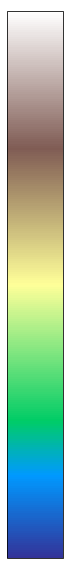

In [44]:
fig, ax = plt.subplots(figsize=(1,20))
fig.subplots_adjust(bottom=0.5)

cmap = mpl.cm.terrain
norm = mpl.colors.Normalize(vmin=0, vmax=R_hmax)
cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
# cb1.outline.set_edgecolor('k')
ax.tick_params(axis='y', colors='white')


# ax.remove()
# cb1.set_label('Human KL Divergence')
plt.plot()
plt.savefig('./L_KL-pngs/R_joint_colorbar.png',bbox_inches='tight',facecolor='k',edgecolor='w')

In [42]:
R_hmax=7.687934938285256

In [38]:
L_hmax=5.722649518067529

In [43]:
R_hmax=8.00090351247032